# Quantum Walk on Line Topology

## What is Quantum Walk?

A quantum (random) walk is the quantum counterpart of a classical random walk, where the walker (particle) follows a probabilistic path. Quantum random walks can outperform classical random walks in certain computational tasks, such as search algorithms and solving specific mathematical problems more efficiently. They form the basis for some of the most promising quantum algorithms, providing potential speedups for problems that are intractable for classical computers.

## Objective:

The goal of this quantum program is to simulate a quantum random walk on a line topology with 16 nodes.

In a line topology, the nodes are arranged sequentially, and each node is connected to its immediate neighbors. For example, consider a line of 16 nodes numbered from 0 to 15. In this walk, the walker would move from its current node to an adjacent node (either left or right) with equal probability.

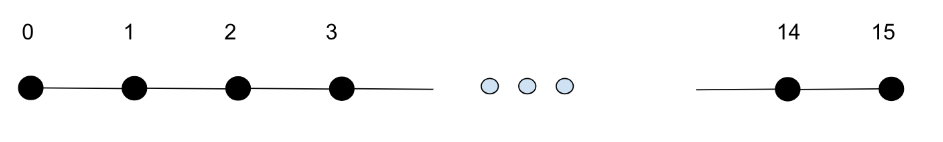

_Image credits: Womanium Quantum + AI Scholarip Program with Classiq on Canva_

Let's start by importing our required packages and setting the number of qubits as 4 ($log_2(16)$)

In [1]:
from classiq import *
from classiq.qmod.symbolic import logical_or
from classiq.execution import ExecutionPreferences

In [3]:
size = 4 # Number of qubits to represent the vertices (log2 of 16 nodes)
num_nodes = 2**size # Total number of nodes (16 nodes)

The algorithm will include two major steps:
- Coin Operator: determines the walker's movement probabilities
- Shift Operator: execute actual movement

Let's look at each operator one by one.

## Coin Operator

The coin operator, a quantum analog of flipping a coin, which determines the walker's movement probabilities. The coin operator transforms the walker's state by assigning amplitudes to move left or right from each node. For instance, if the walker is at node 0, the coin operator will set the probability to move to node 1. If the walker is at node 15, it will set the probability to move to node 14. For nodes in between, the probabilities are distributed evenly to move either left or right.

For our process, we'll setup the probability based on above discussed idea. We, then, use diffuser oracle to to amplify the probabilities of adjacent nodes.

In [4]:
# Function to prepare a qubit in the |-> state
@qfunc
def prepare_minus(x: QBit):
    """
    Prepares a qubit in the |-> state.
    
    Args:
        x (QBit): The qubit to prepare.
    """
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    """
    Implements a diffuser oracle for Grover's algorithm.
    
    Args:
        aux (Output[QNum]): Auxiliary qubit.
        x (QNum): QNum representing the node to check.
    """
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):
    """
    Implements the zero diffuser for the quantum walk.
    
    Args:
        x (QNum): QNum representing the current node.
    """
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    """
    Defines the coin operation for the quantum walk.
    
    Args:
        i (int): Current node index.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    prob = [0]*num_nodes  # Initialize probability vector for 16 nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    print(f'Node={i}, prob vec ={prob}')
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the coin operator to all vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    for i in range(num_nodes):
        C_iteration(i,vertices,adjacent_vertices)

## Shift Operator

After determining the movement probabilities, the shift operator is applied. This operator executes the movement by swapping the walker's state between nodes according to the amplitudes set by the coin operator. If the quantum state of the walker indicates a move from node 7 to nodes 6 and 8, the shift operator adjusts the state to reflect these new positions. Importantly, quantum interference can occur during this step, where the probability amplitudes of different paths combine, enhancing or diminishing the likelihood of certain outcomes.

In [5]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    """
    Oracle that checks if two vertices are adjacent.
    
    Args:
        res (Output[QBit]): Result bit to store the adjacency check.
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    """
    Swaps the values of two QArrays bit by bit.
    
    Args:
        x (QArray[QBit]): First QArray of qubits.
        y (QArray[QBit]): Second QArray of qubits.
    """
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    """
    Applies the shift operator to swap vertices with their adjacent vertices.
    
    Args:
        vertices (QNum): QNum representing the vertices.
        adjacent_vertices (QNum): QNum representing the adjacent vertices.
    """
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

## Putting them together

Let's put all these together to form a quantum walk.

The process begins by initializing the walker in a superposition of all possible positions along the line. This is typically achieved using quantum gates, such as the Hadamard gate, which creates an equal probability amplitude for the walker to be found at any of the 16 nodes. In mathematical terms, the walker's initial state can be represented as a superposition of basis states ∣0⟩, ∣1⟩,..., ∣15⟩, where each basis state corresponds to one of the nodes.

In [6]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    """
    Main function to perform the quantum random walk.
    
    Args:
        vertices (Output[QNum]): Output QNum to represent vertices.
        adjacent_vertices (Output[QNum]): Output QNum to represent adjacent vertices.
    """
    allocate(size, vertices)  # Allocate qubits for vertices
    hadamard_transform(vertices)  # Apply Hadamard transform to initialize superposition
    allocate(size, adjacent_vertices)  # Allocate qubits for adjacent vertices
    
    C_operator(vertices, adjacent_vertices)  # Apply coin operator
    S_operator(vertices, adjacent_vertices)  # Apply shift operator

Let's create the circuit.

In [7]:
# Create and synthesize the quantum model
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Node=0, prob vec =[0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node

Here's the circuit we get...

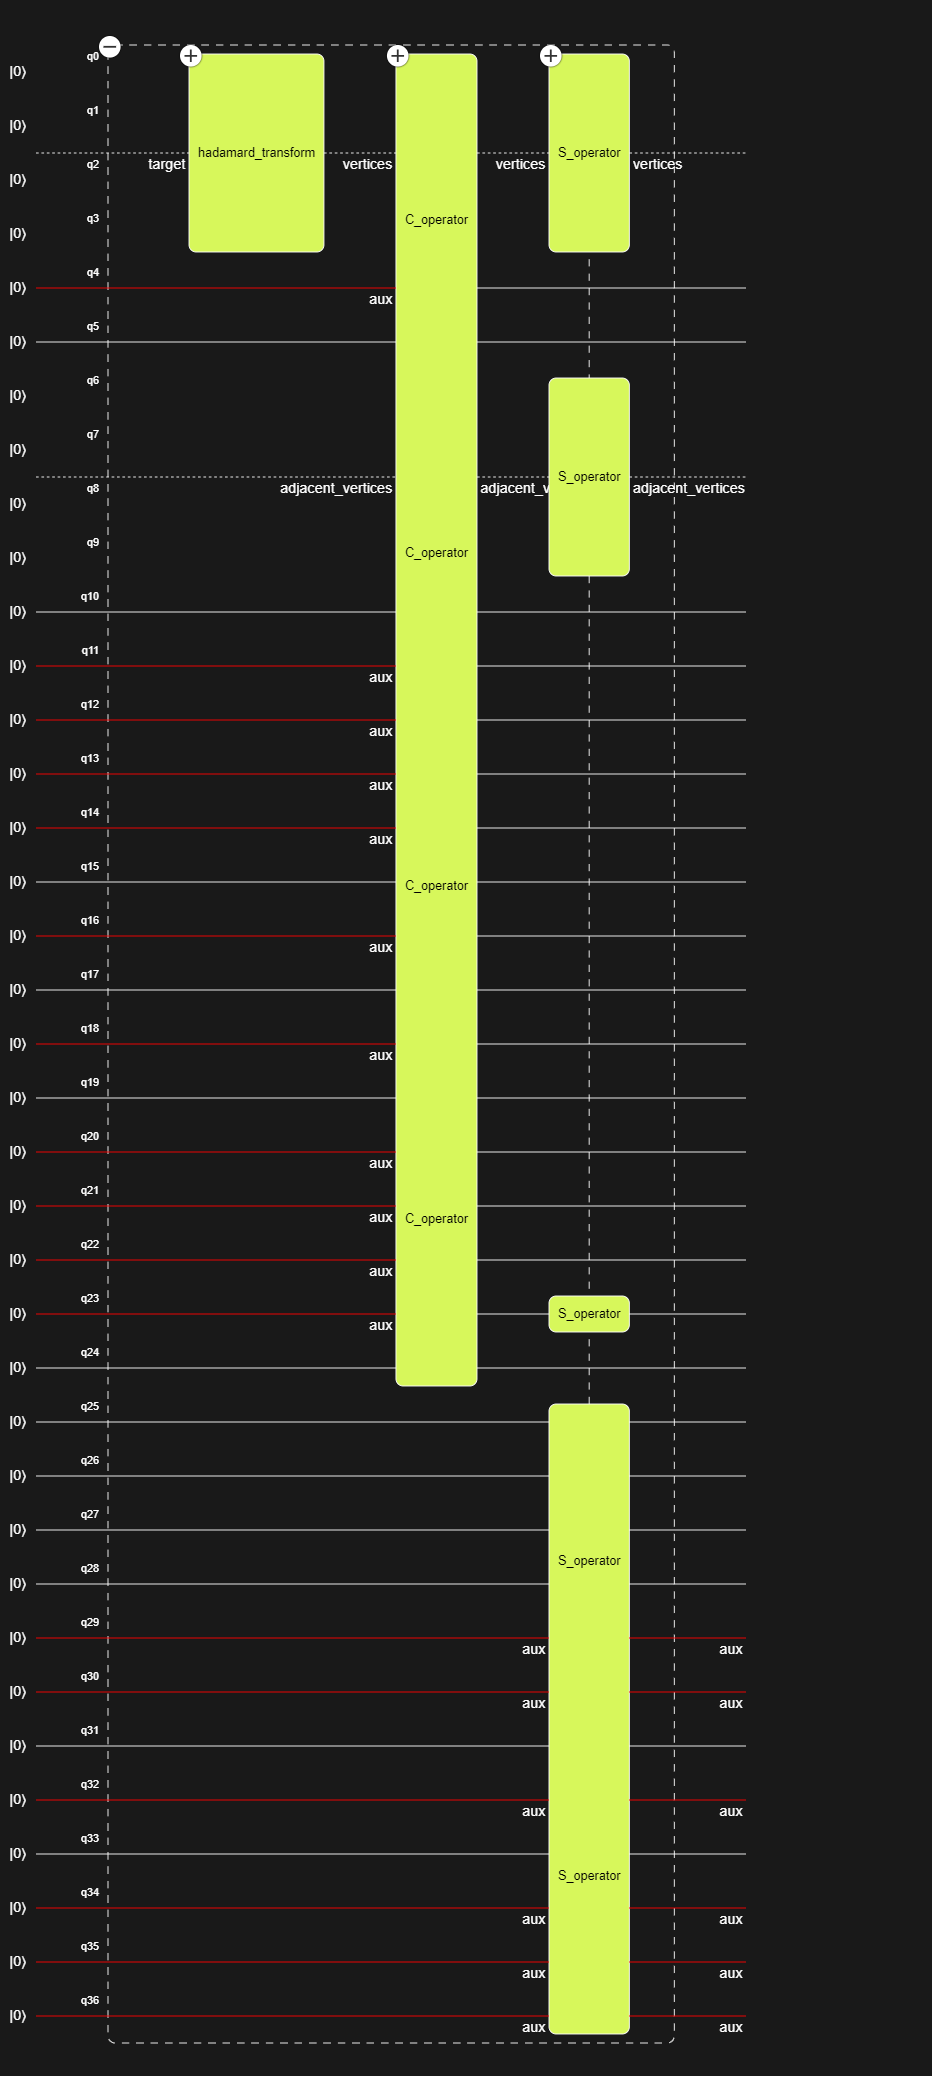

Zooming in the circuit we can observe that circuit implemented our desired algorithm correctly.

Since the circuit is ver wide, it's not possible to include it here. However, below are some screenshots to make understand how it works.

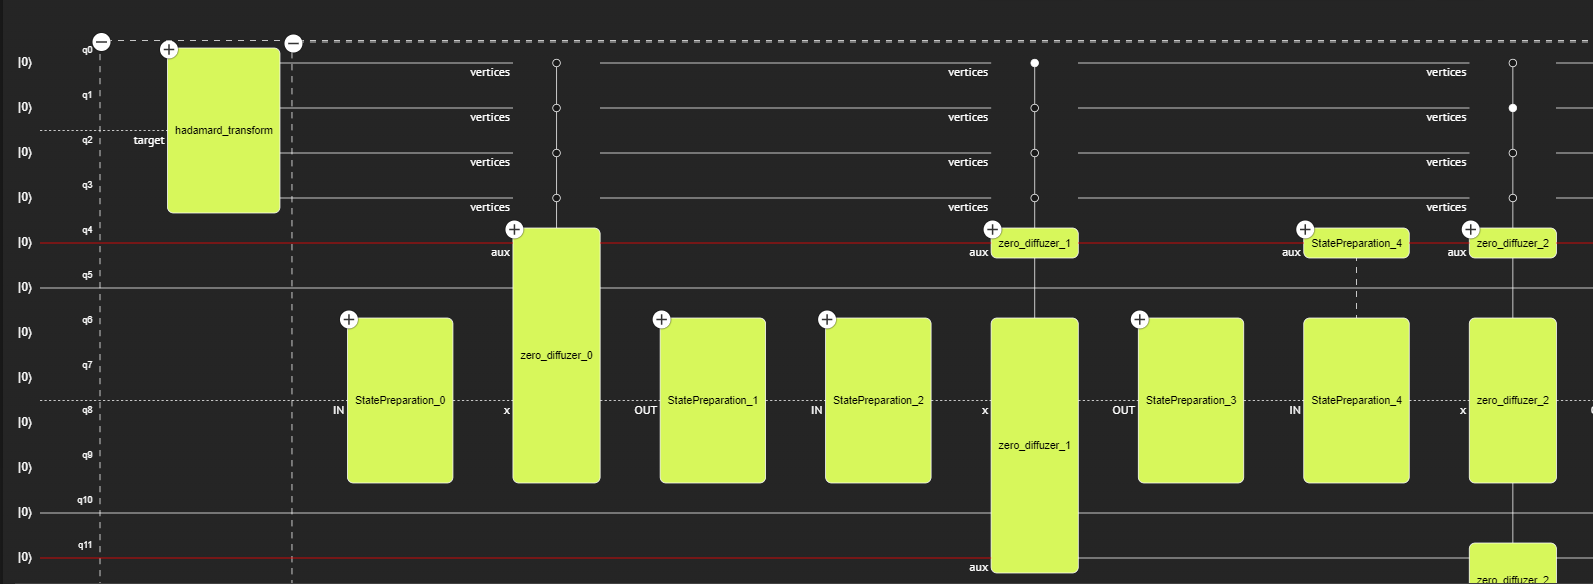

The screenshot depicts a segment of the quantum circuit corresponding to the Coin operator applied in the quantum random walk algorithm.

The circuit begins with the application of Hadamard gates to creates an equal superposition of all possible states (positions), allowing the walker to have a non-zero probability of being at any of the 16 nodes. State preparation block prepares the probabilities for moving to adjacent vertices. For each node, this function sets the probability amplitudes for the walker to move to its neighboring nodes. Zero diffuser blockapplies the diffusion operator to ensure that the probabilities are correctly distributed. The auxiliary qubit (aux) is used to facilitate this operation. The operations are applied sequentially to each node.

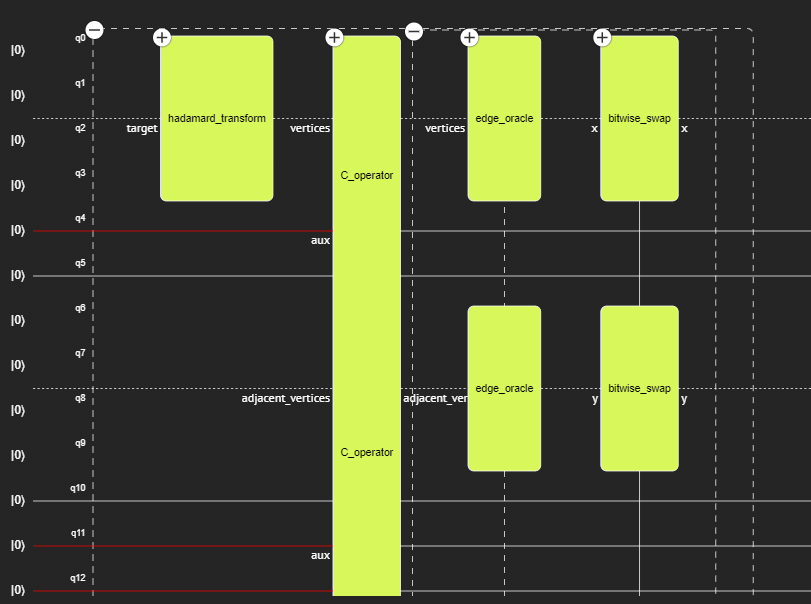

Here, it can be observed how Shift operator is being implemented.

Edge oracle block checks if the current vertex and an adjacent vertex are connected by an edge. If the vertices are adjacent, it sets a flag qubit to indicate this. If the edge oracle indicates adjacency, the bitwise swap operation swaps the states of the vertices and adjacent_vertices qubits. This swap simulates the walker's movement to the adjacent vertex. The dashed control lines indicate that the bitwise swap operation is conditional based on the adjacency check by the edge_oracle. This ensures that the swap only occurs if the vertices are indeed adjacent.